In [286]:
#pip installing 
#!pip install matplotlib seaborn pillow scikit-image scikit-learn numpy

# Import required libraries
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, UnidentifiedImageError
import numpy as np
from skimage.feature import hog
from skimage import exposure
import pickle
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from multiprocessing.pool import ThreadPool
from concurrent.futures import ThreadPoolExecutor
from glob import glob
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.colors as mcolors
from tqdm import tqdm
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



In [287]:

# Creating image path
base_dir = 'data weed classification'
splits = ['train', 'val', 'test']
image_paths = []
labels = []

# Iterating through each splits and collecting image paths 
for split in splits:
    split_dir = os.path.join(base_dir, split)
    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        if os.path.isdir(class_dir):
            images = glob(os.path.join(class_dir, '*.jpg')) + glob(os.path.join(class_dir, '*.png'))
            image_paths.extend(images)
            labels.extend([class_name] * len(images))
# Printing total of images found and their classes 
print(f" Total images found: {len(image_paths)}")
print(f" Classes: {set(labels)}")


 Total images found: 786
 Classes: {'charlock', 'cleavers'}


In [288]:
#setting my dataset path
data_path = 'data weed classification'

In [289]:
#counting of images per class in my dataset
def count_images(data_split):
    split_path = os.path.join(data_path, data_split)
    class_counts = {}
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_counts = count_images('train')
val_counts = count_images('val')
test_counts = count_images('test')

print("Train:", train_counts)
print("Validation:", val_counts)
print("Test:", test_counts)


Train: {'cleavers': 208, 'charlock': 272}
Validation: {'cleavers': 58, 'charlock': 90}
Test: {'cleavers': 68, 'charlock': 90}


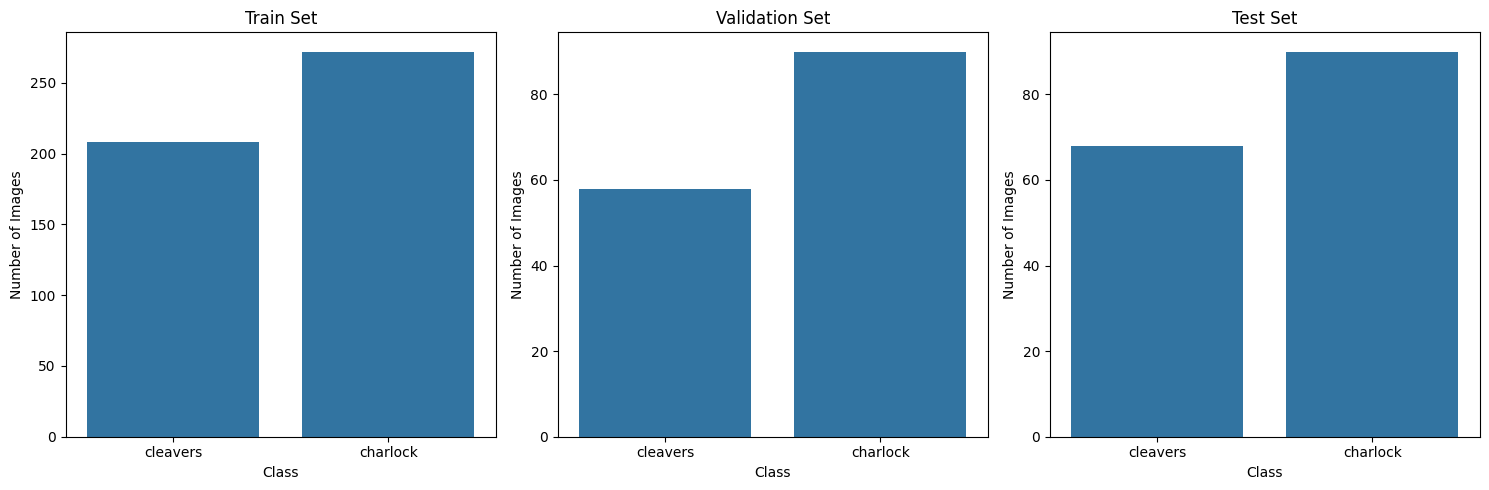

In [290]:
# Defining my data splits and corresponding class counts
splits = ['Train', 'Validation', 'Test']
data = [train_counts, val_counts, test_counts]

# Creatin a figure with subplot to visualize the class distribution for each data splots 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, split in enumerate(splits):
    sns.barplot(x=list(data[i].keys()), y=list(data[i].values()), ax=axes[i])
    axes[i].set_title(f'{split} Set')
    axes[i].set_ylabel('Number of Images')
    axes[i].set_xlabel('Class')
plt.tight_layout()
plt.show()


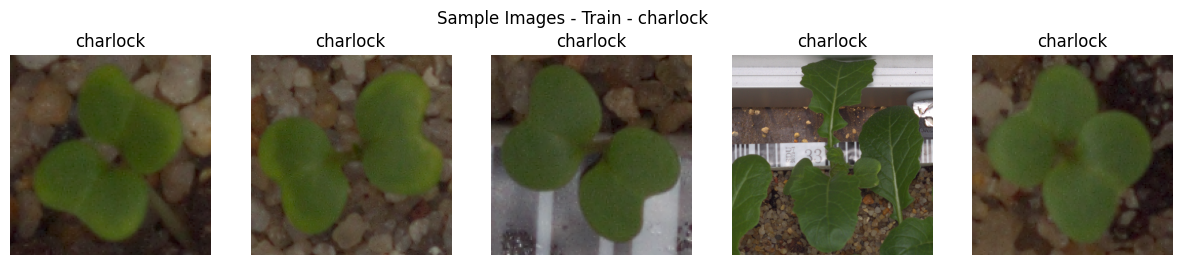

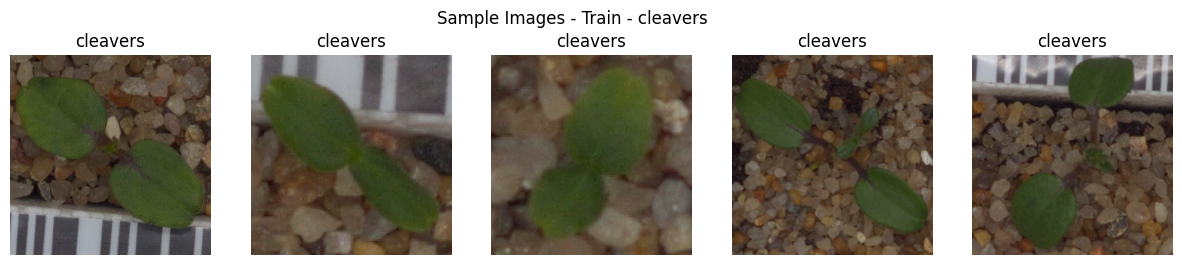

In [291]:
# Creating a function to displa images from classes
def show_sample_images(split, class_name, num_samples=5):
    path = os.path.join(data_path, split, class_name)
    
# Getting a list of image files in this directory    
    images = os.listdir(path)[:num_samples]

#Create a subplot to display images    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, img_file in enumerate(images):
        img = Image.open(os.path.join(path, img_file))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(class_name)
    plt.suptitle(f"Sample Images - {split.capitalize()} - {class_name}")
    plt.show()

# Show example images from each class
show_sample_images('train', 'charlock')
show_sample_images('train', 'cleavers')


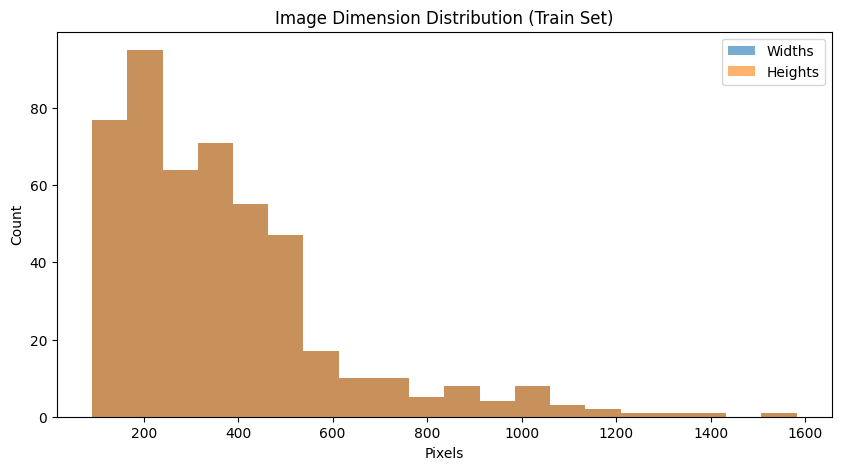

In [292]:
#checking images sizes
def get_image_sizes(split):
    sizes = []
    for class_name in os.listdir(os.path.join(data_path, split)):
        class_path = os.path.join(data_path, split, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path)
                sizes.append(img.size)  # (width, height)
            except:
                continue
    return sizes

sizes = get_image_sizes('train')
widths, heights = zip(*sizes)

plt.figure(figsize=(10,5))
plt.hist(widths, bins=20, alpha=0.6, label='Widths')
plt.hist(heights, bins=20, alpha=0.6, label='Heights')
plt.title('Image Dimension Distribution (Train Set)')
plt.xlabel('Pixels')
plt.ylabel('Count')
plt.legend()
plt.show()


#### Doing it for all the folders

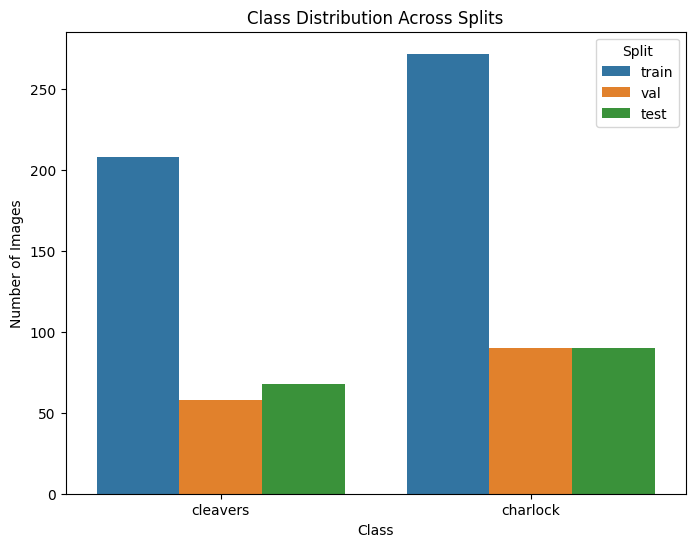

In [294]:


splits = ['train', 'val', 'test']
all_counts = []

for split in splits:
    split_path = os.path.join("data weed classification", split)
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        count = len(os.listdir(class_path))
        all_counts.append({'Split': split, 'Class': class_name, 'Count': count})

# Converting to DataFrame and plot
import pandas as pd
df = pd.DataFrame(all_counts)

plt.figure(figsize=(8,6))
sns.barplot(data=df, x='Class', y='Count', hue='Split')
plt.title('Class Distribution Across Splits')
plt.ylabel('Number of Images')
plt.xlabel('Class')
plt.show()


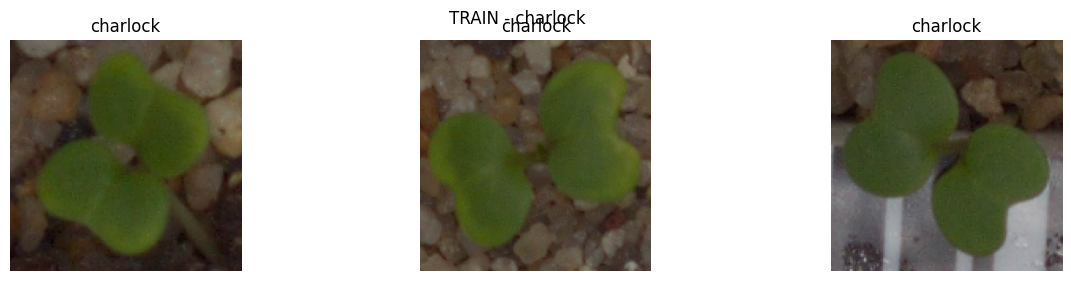

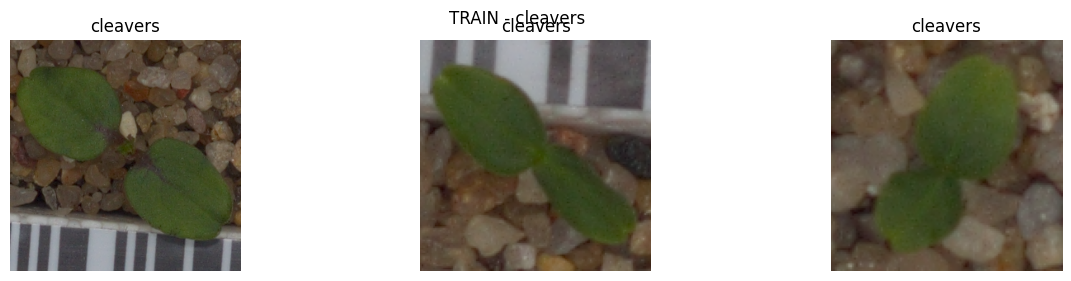

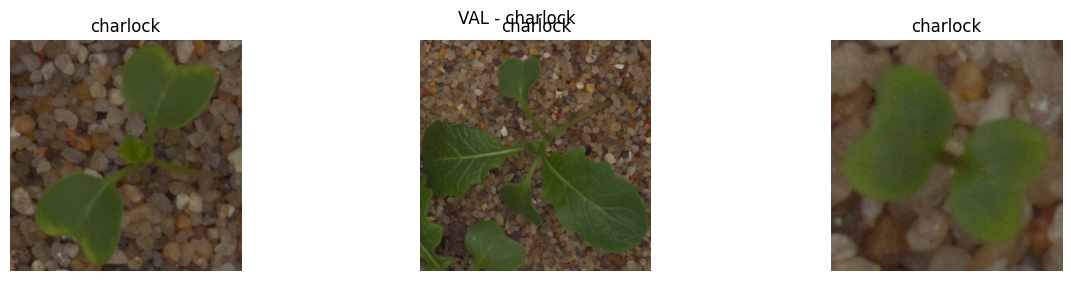

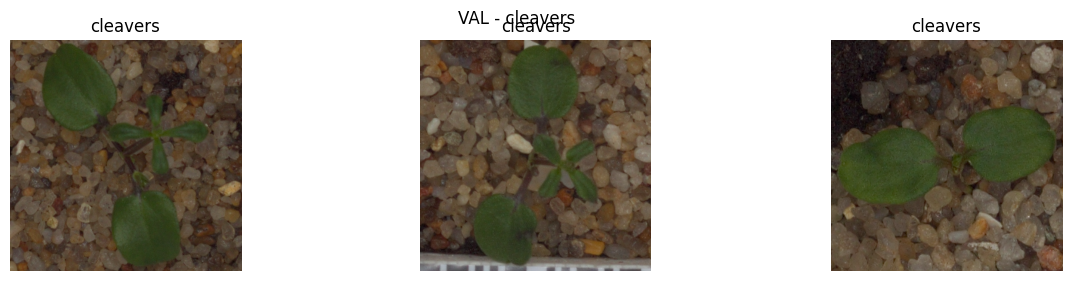

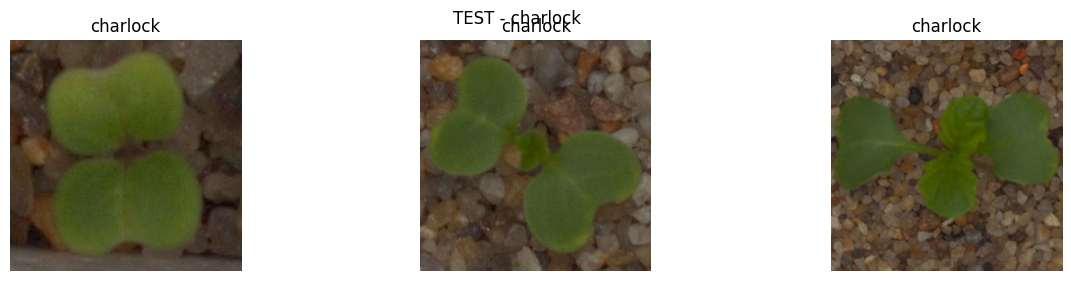

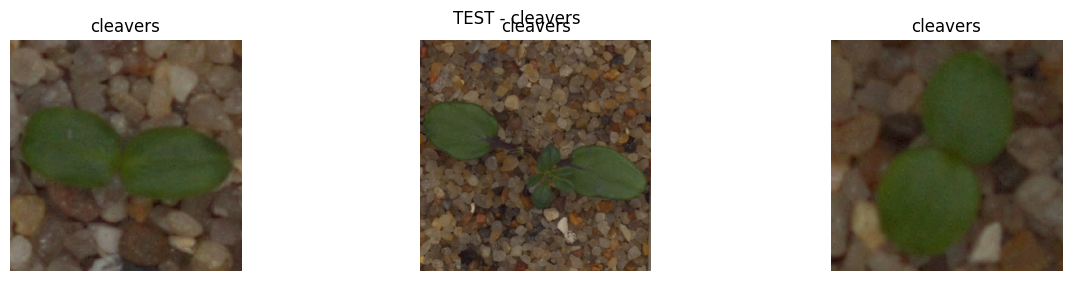

In [295]:
###Showing Sample of Each Split Class
def show_samples_all(splits=['train', 'val', 'test'], class_names=['charlock', 'cleavers'], num_samples=3):
    for split in splits:
        for class_name in class_names:
            path = os.path.join("data weed classification", split, class_name)
            images = os.listdir(path)[:num_samples]
            fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
            for i, img_file in enumerate(images):
                img = Image.open(os.path.join(path, img_file))
                axes[i].imshow(img)
                axes[i].axis('off')
                axes[i].set_title(f'{class_name}')
            plt.suptitle(f'{split.upper()} - {class_name}')
            plt.show()

show_samples_all()


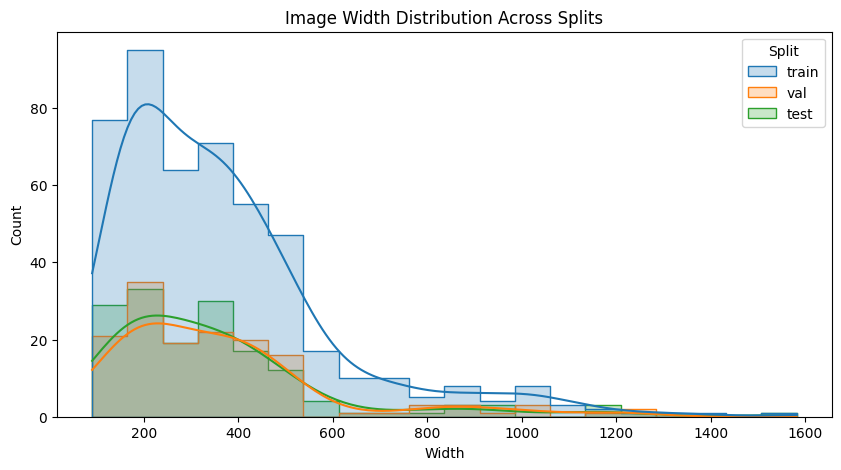

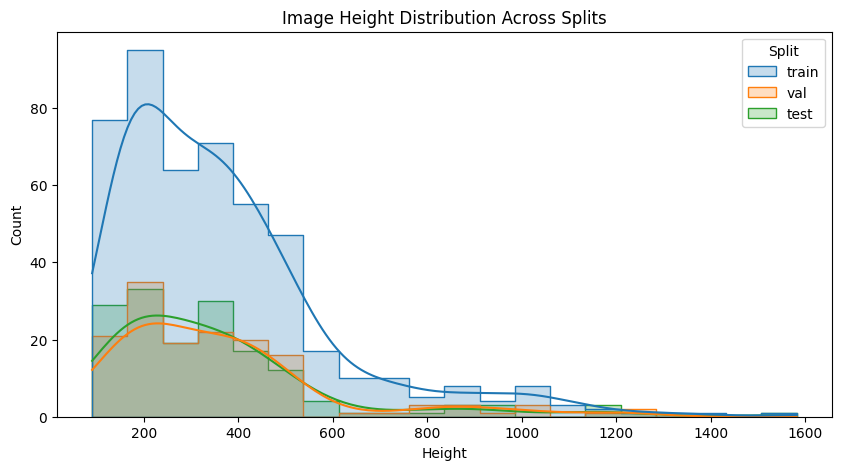

In [296]:
# Images Size Distribution 
def get_sizes_all(splits=['train', 'val', 'test']):
    size_data = []
    for split in splits:
        for class_name in os.listdir(os.path.join("data weed classification", split)):
            class_path = os.path.join("data weed classification", split, class_name)
            for img_name in os.listdir(class_path):
                try:
                    img = Image.open(os.path.join(class_path, img_name))
                    w, h = img.size
                    size_data.append({'Split': split, 'Class': class_name, 'Width': w, 'Height': h})
                except:
                    continue
    return pd.DataFrame(size_data)

size_df = get_sizes_all()

plt.figure(figsize=(10,5))
sns.histplot(size_df, x='Width', hue='Split', bins=20, element='step', kde=True)
plt.title("Image Width Distribution Across Splits")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(size_df, x='Height', hue='Split', bins=20, element='step', kde=True)
plt.title("Image Height Distribution Across Splits")
plt.show()


In [297]:
##Preprocessing 

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Defining my dataset path
data_path = "data weed classification"
splits = ['train', 'val', 'test']
classes = ['charlock', 'cleavers']

# Creating output folder for preprocessed images
output_path = "preprocessed_data"
os.makedirs(output_path, exist_ok=True)

# Looping through all images
for split in splits:
    for cls in classes:
        input_folder = os.path.join(data_path, split, cls)
        output_folder = os.path.join(output_path, split, cls)
        os.makedirs(output_folder, exist_ok=True)

        for file in tqdm(os.listdir(input_folder), desc=f"{split}/{cls}"):
            img_path = os.path.join(input_folder, file)
            img = cv2.imread(img_path)
            if img is None:
                continue

            # Step 1: Resize to 224x224
            img = cv2.resize(img, (224, 224))

            # Step 2: Convert to HSV color space
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

            # Step 3: Mask green color range
            lower_green = np.array([35, 40, 40])
            upper_green = np.array([85, 255, 255])
            mask = cv2.inRange(hsv, lower_green, upper_green)
            masked_img = cv2.bitwise_and(img, img, mask=mask)

            # Step 4: Apply Gaussian Blur to reduce noise
            blurred_img = cv2.GaussianBlur(masked_img, (5, 5), 0)

            # Save the preprocessed image
            output_img_path = os.path.join(output_folder, file)
            cv2.imwrite(output_img_path, blurred_img)


test/cleavers: 100%|███████████████████████████| 68/68 [00:00<00:00, 200.71it/s]


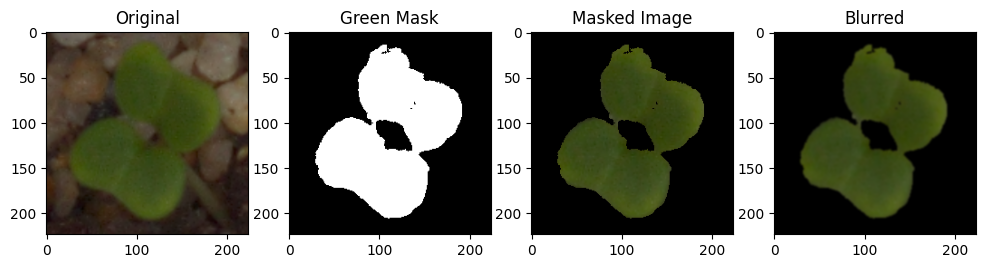

In [298]:
 # Visualizing the Preprocessed Images
sample_img = cv2.imread(os.path.join(data_path, 'train/charlock', os.listdir(os.path.join(data_path, 'train/charlock'))[0]))
sample_img = cv2.resize(sample_img, (224, 224))
hsv = cv2.cvtColor(sample_img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, np.array([35, 40, 40]), np.array([85, 255, 255]))
masked = cv2.bitwise_and(sample_img, sample_img, mask=mask)
blurred = cv2.GaussianBlur(masked, (5, 5), 0)

plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1); plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)); plt.title('Original')
plt.subplot(1, 4, 2); plt.imshow(mask, cmap='gray'); plt.title('Green Mask')
plt.subplot(1, 4, 3); plt.imshow(cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)); plt.title('Masked Image')
plt.subplot(1, 4, 4); plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB)); plt.title('Blurred')
plt.show()


In [299]:
#Feature Extraction Functions
# RGB Histogram
def extract_rgb_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    return cv2.normalize(hist, hist).flatten()

# SIFT Features
def extract_sift_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is None:
        return np.zeros(128)
    return np.mean(descriptors, axis=0)

# HOG Features
def extract_hog_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, _ = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys', visualize=True)
    return features

# Hu Moments
def extract_hu_moments(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray)
    hu_moments = cv2.HuMoments(moments)
    return hu_moments.flatten()




def extract_rgb_features(image):
    image_np = np.array(image.convert('RGB'))  # Convert PIL Image to RGB NumPy array
    resized = cv2.resize(image_np, (224, 224))  # Resize for consistency
    return resized.flatten()  # Flatten to 1D vector



In [300]:
#Feature Extraction Loop
data_dir = "preprocessed_data"
splits = ['train', 'val', 'test']
classes = ['charlock', 'cleavers']

# Dictionary to hold features and labels
features_rgb_sift = []
features_rgb_hog = []
features_rgb_hu = []

labels = []

for split in splits:
    for cls in classes:
        folder = os.path.join(data_dir, split, cls)
        for file in tqdm(os.listdir(folder), desc=f"{split}/{cls}"):
            file_path = os.path.join(folder, file)
            image = cv2.imread(file_path)
            
            if image is None:
                continue

            # Feature Set 1: RGB + SIFT
            rgb_feat = extract_rgb_histogram(image)
            sift_feat = extract_sift_features(image)
            combined_sift = np.hstack([rgb_feat, sift_feat])
            features_rgb_sift.append(combined_sift)

            # Feature Set 2: RGB + HOG
            hog_feat = extract_hog_features(image)
            combined_hog = np.hstack([rgb_feat, hog_feat])
            features_rgb_hog.append(combined_hog)

            # Feature Set 3: RGB + Hu Moments
            hu_feat = extract_hu_moments(image)
            combined_hu = np.hstack([rgb_feat, hu_feat])
            features_rgb_hu.append(combined_hu)

            labels.append(cls)


test/cleavers: 100%|████████████████████████████| 68/68 [00:01<00:00, 41.29it/s]


In [301]:
#Saving Features for later use 
# Save features and labels
joblib.dump((features_rgb_sift, labels), 'features_rgb_sift.pkl')
joblib.dump((features_rgb_hog, labels), 'features_rgb_hog.pkl')
joblib.dump((features_rgb_hu, labels), 'features_rgb_hu.pkl')


['features_rgb_hu.pkl']

In [302]:
import joblib

X, y = joblib.load('compiled_rgb_sift.pkl') 


In [303]:


# Loading my RGB+Hu feature dataset
X, y = joblib.load('compiled_rgb_hu.pkl')

# Splitting and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training models
logreg = LogisticRegression(max_iter=1000)
svm = SVC()
rf = RandomForestClassifier()

logreg.fit(X_train_scaled, y_train)
svm.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)

# Saving models
joblib.dump(logreg, 'logistic_regression_model.pkl')
joblib.dump(svm, 'svm_model.pkl')
joblib.dump(rf, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')  # Save scaler too

print(" Models trained and saved successfully.")


 Models trained and saved successfully.


In [304]:
# Visualization for Inspection

def visualize_processing_steps(image_path):
    original = cv2.imread(image_path)
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    hsv = cv2.cvtColor(original, cv2.COLOR_BGR2HSV)

    # Defining green range
    lower_green = (25, 40, 40)
    upper_green = (85, 255, 255)
    mask = cv2.inRange(hsv, lower_green, upper_green)

    masked = cv2.bitwise_and(original, original, mask=mask)
    blurred = cv2.GaussianBlur(masked, (5, 5), 0)

    # Converting for visualization
    masked_rgb = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)
    blurred_rgb = cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB)

    # Showing images
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(original_rgb)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))
    plt.title('HSV Image')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(masked_rgb)
    plt.title('Masked Green Area')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(blurred_rgb)
    plt.title('Blurred Image')
    plt.axis('off')

    plt.show()

# Visualizing Images
visualize_processing_steps("data weed classification/train/charlock/charlock.246.png")  # change to a real path


In [305]:
# Visualizing all the feature extraction image together for easy compariosn


def visualize_all_features(image_path):
    # Load and resize image
    original = cv2.imread(image_path)
    if original is None:
        print(f"Could not load image at {image_path}")
        return

    resized = cv2.resize(original, (224, 224))
    rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)

    # HSV masking
    hsv = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)
    lower_green = (25, 40, 40)
    upper_green = (85, 255, 255)
    mask = cv2.inRange(hsv, lower_green, upper_green)
    masked = cv2.bitwise_and(resized, resized, mask=mask)
    masked_rgb = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)

    # SIFT
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, _ = sift.detectAndCompute(gray, None)
    sift_img = cv2.drawKeypoints(resized, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    sift_rgb = cv2.cvtColor(sift_img, cv2.COLOR_BGR2RGB)

    # HOG
    gray_resized = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    hog_features, hog_image = hog(gray_resized, pixels_per_cell=(16, 16),
                                  cells_per_block=(2, 2), visualize=True, channel_axis=None)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Hu Moments (visualizing grayscale image)
    moments = cv2.moments(gray_resized)
    hu_moments = cv2.HuMoments(moments).flatten()

    # Visualization
    plt.figure(figsize=(16, 8))

    plt.subplot(2, 3, 1)
    plt.imshow(rgb)
    plt.title("Original RGB")
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(masked_rgb)
    plt.title("HSV Masked (Green)")
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(sift_rgb)
    plt.title("SIFT Keypoints")
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(hog_image_rescaled, cmap='gray')
    plt.title("HOG Features")
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.text(0.1, 0.5, '\n'.join([f"Hu[{i}]: {hu:.2e}" for i, hu in enumerate(hu_moments)]), fontsize=12)
    plt.title("Hu Moments (Text)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualizing images
visualize_all_features("data weed classification/train/charlock/charlock.246.png") 


In [306]:

# Feature Extraction Functions

def extract_rgb_features(image):
    resized = cv2.resize(image, (224, 224))
    return resized.flatten()

def extract_sift_features(image, vector_size=100):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is not None:
        descriptors = descriptors.flatten()
        if descriptors.size < vector_size * 128:
            descriptors = np.pad(descriptors, (0, vector_size * 128 - descriptors.size), 'constant')
        else:
            descriptors = descriptors[:vector_size * 128]
    else:
        descriptors = np.zeros(vector_size * 128)
    return descriptors

def extract_hog_features(image):
    image_gray = rgb2gray(cv2.resize(image, (128, 128)))
    features, _ = hog(image_gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
    return features

def extract_hu_moments(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray)
    hu = cv2.HuMoments(moments).flatten()
    return hu

# Paths and Initialization
data_path = "data weed classification"
splits = ['train', 'val', 'test']
all_features = []
all_labels = []

# Looping through dataset 
for split in splits:
    for class_name in os.listdir(os.path.join(data_path, split)):
        class_dir = os.path.join(data_path, split, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image = cv2.imread(img_path)

            if image is None:
                continue  # skip unreadable files

            # Extract Features
            rgb_feat = extract_rgb_features(image)
            sift_feat = extract_sift_features(image)
            hog_feat = extract_hog_features(image)
            hu_feat = extract_hu_moments(image)

            combined_feat = np.concatenate([rgb_feat, sift_feat, hog_feat, hu_feat])
            all_features.append(combined_feat)
            all_labels.append(class_name)

#  Serializing the features 
data = {
    'features': all_features,
    'labels': all_labels
}

with open('weed_features_dataset.pkl', 'wb') as f:
    pickle.dump(data, f)

print(" Features extracted and serialized successfully.")


 Features extracted and serialized successfully.


In [307]:


#  Defining the directory where  images are located
image_directory = 'data weed classification' 

# Listing all image files in the directory 
image_files = [f for f in os.listdir(image_directory) if f.endswith('.jpg') or f.endswith('.png')]

# Defining the labels manually or based on  file structure

labels = ['charlock' if 'charlock' in filename else 'cleavers' for filename in image_files]

# Generating the list of image file paths
image_paths = [os.path.join(image_directory, filename) for filename in image_files]

# Verifying by printing
print(f"Image paths: {image_paths[:5]}")
print(f"Labels: {labels[:5]}")


Image paths: []
Labels: []


In [308]:


# Base directory where images are stored
base_dir = 'data weed classification'  

# Subdirectories for train, test, val
splits = ['train', 'val', 'test']
image_paths = []
labels = []

# Looping through splits (train, val, test)
for split in splits:
    split_dir = os.path.join(base_dir, split)  
    
    # Looping through the classes (charlock, cleavers)
    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)  
        
        if os.path.isdir(class_dir):
            # Adding all image files (JPG, PNG) from the current class folder
            images = glob(os.path.join(class_dir, '*.jpg')) + glob(os.path.join(class_dir, '*.png'))
            image_paths.extend(images)
            labels.extend([class_name] * len(images))  

# Verifying the output
print(f"Image paths: {image_paths[:5]}")
print(f"Labels: {labels[:5]}")


Image paths: ['data weed classification/train/cleavers/cleavers.270.png', 'data weed classification/train/cleavers/cleavers.264.png', 'data weed classification/train/cleavers/cleavers.258.png', 'data weed classification/train/cleavers/cleavers.304.png', 'data weed classification/train/cleavers/cleavers.310.png']
Labels: ['cleavers', 'cleavers', 'cleavers', 'cleavers', 'cleavers']


Logistic Regression on RGB+Hu:
  Accuracy : 0.9177
  Precision: 0.8873
  Recall   : 0.9265
  F1 Score : 0.9065

Support Vector Machine on RGB+Hu:
  Accuracy : 0.8861
  Precision: 0.8788
  Recall   : 0.8529
  F1 Score : 0.8657

Random Forest on RGB+Hu:
  Accuracy : 0.9304
  Precision: 0.9014
  Recall   : 0.9412
  F1 Score : 0.9209



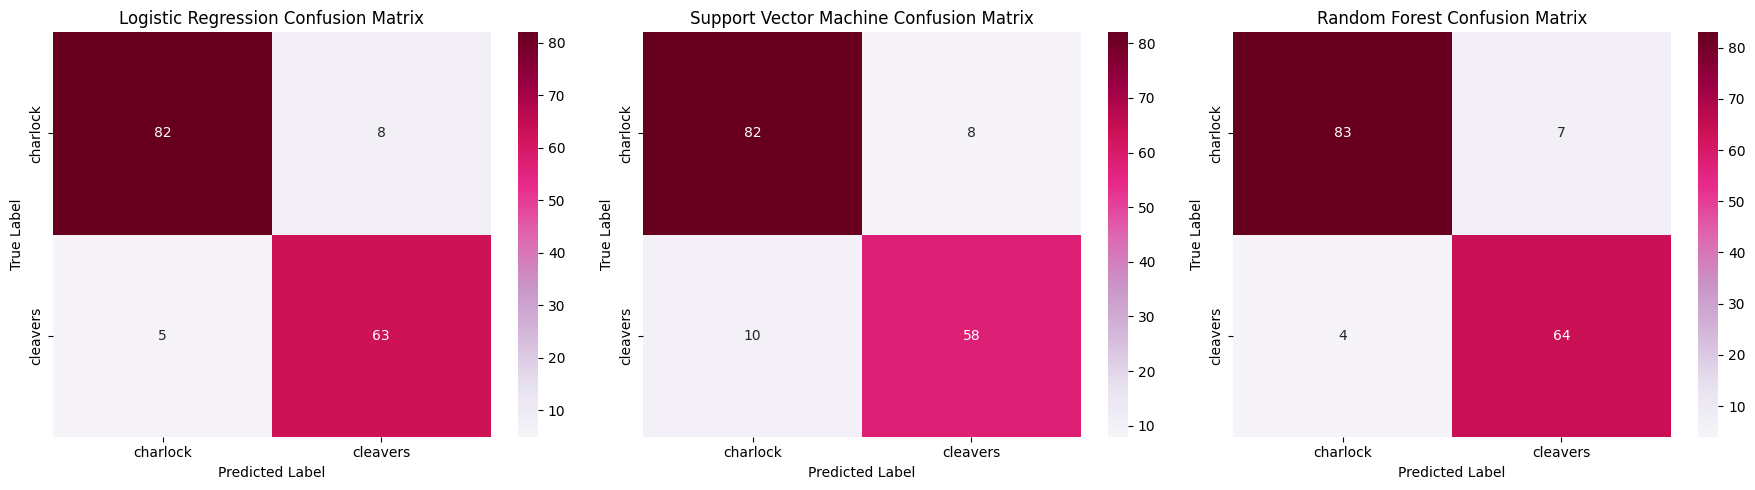

In [309]:

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Loading models and scaler
logreg_model = joblib.load('logistic_regression_model.pkl')
svm_model = joblib.load('svm_model.pkl')
rf_model = joblib.load('random_forest_model.pkl')
scaler = joblib.load('scaler.pkl')

# Loading compiled feature dataset 
X, y = joblib.load('compiled_rgb_hu.pkl')

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling test data
X_test_scaled = scaler.transform(X_test)

# Defining models dictionary for easy iteration
models = {
    "Logistic Regression": logreg_model,
    "Support Vector Machine": svm_model,
    "Random Forest": rf_model
}

# Unique class labels for display
classes = np.unique(y)

# Storing confusion matrices
conf_matrices = {}

# Evaluating each model
for name, model in models.items():
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average='binary', pos_label='cleavers')
    rec = recall_score(y_test, preds, average='binary', pos_label='cleavers')
    f1 = f1_score(y_test, preds, average='binary', pos_label='cleavers')
    cm = confusion_matrix(y_test, preds)
    conf_matrices[name] = cm

    print(f"{name} on RGB+Hu:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1 Score : {f1:.4f}\n")


# Plotting confusion matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='PuRd',
                xticklabels=classes, yticklabels=classes, ax=ax)
    ax.set_title(f"{name} Confusion Matrix", fontsize=12)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Precision scores for bar chart
precision_scores = [
    precision_score(y_test, model.predict(X_test_scaled), average='binary', pos_label='cleavers')
    for model in models.values()
]
model_names = list(models.keys())
colors = ['#FFC0CB', '#800080', '#EE82EE']  # pink, purple, violet

# Plot bar chart for precision
plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, precision_scores, color=colors)
plt.title("Precision Scores (RGB + Hu)", fontsize=14)
plt.ylabel("Precision", fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add precision values on top of bars
for bar, score in zip(bars, precision_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, score + 0.02, f"{score:.2f}", 
             ha='center', fontsize=11)

plt.tight_layout()
plt.show()



In [310]:

from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Define base directory for the dataset
base_dir = 'data weed classification'
splits = ['train', 'val', 'test']
image_paths = []
labels = []

# 1. Gathering all images and their labels from train/val/test splits
for split in splits:
    split_dir = os.path.join(base_dir, split)
    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        if os.path.isdir(class_dir):
            images = glob(os.path.join(class_dir, '*.jpg')) + glob(os.path.join(class_dir, '*.png'))
            image_paths.extend(images)
            labels.extend([class_name] * len(images))

print(f" Total images found: {len(image_paths)}")
print(f" Classes: {set(labels)}")

# 2. Setting dataset path
data_path = 'data weed classification'

# 3. Counting images per class in the dataset
def count_images(data_split):
    split_path = os.path.join(data_path, data_split)
    class_counts = {}
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_counts = count_images('train')
val_counts = count_images('val')
test_counts = count_images('test')

print("Train:", train_counts)
print("Validation:", val_counts)
print("Test:", test_counts)

# 4. Feature Extraction Loop for RGB + SIFT, RGB + HOG, RGB + Hu
data_dir = "preprocessed_data"
splits = ['train', 'val', 'test']
classes = ['charlock', 'cleavers']

# Initializing lists for storing feature sets
features_rgb_sift = []
features_rgb_hog = []
features_rgb_hu = []
labels = []

# Extracting features from images
for split in splits:
    for cls in classes:
        folder = os.path.join(data_dir, split, cls)
        for file in tqdm(os.listdir(folder), desc=f"{split}/{cls}"):
            file_path = os.path.join(folder, file)
            image = cv2.imread(file_path)
            if image is None:
                continue

            # Feature Set 1: RGB + SIFT
            rgb_feat = extract_rgb_histogram(image)  
            sift_feat = extract_sift_features(image)  
            combined_sift = np.hstack([rgb_feat, sift_feat])
            features_rgb_sift.append(combined_sift)

            # Feature Set 2: RGB + HOG
            hog_feat = extract_hog_features(image)  
            combined_hog = np.hstack([rgb_feat, hog_feat])
            features_rgb_hog.append(combined_hog)

            # Feature Set 3: RGB + Hu Moments
            hu_feat = extract_hu_moments(image)  #
            combined_hu = np.hstack([rgb_feat, hu_feat])
            features_rgb_hu.append(combined_hu)

            labels.append(cls)

# 5. Saving features and labels
joblib.dump((features_rgb_sift, labels), 'features_rgb_sift.pkl')
joblib.dump((features_rgb_hog, labels), 'features_rgb_hog.pkl')
joblib.dump((features_rgb_hu, labels), 'features_rgb_hu.pkl')

# 6. Loading  RGB+Hu feature dataset
X, y = joblib.load('features_rgb_hu.pkl') 

# Splitting and scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. Training models
logreg = LogisticRegression(max_iter=1000)
svm = SVC()
rf = RandomForestClassifier()

logreg.fit(X_train_scaled, y_train)
svm.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)

# 8. Saving models
joblib.dump(logreg, 'logistic_regression_model.pkl')
joblib.dump(svm, 'svm_model.pkl')
joblib.dump(rf, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')  # Save scaler too

print(" Models trained and saved successfully.")


 Total images found: 786
 Classes: {'charlock', 'cleavers'}
Train: {'cleavers': 208, 'charlock': 272}
Validation: {'cleavers': 58, 'charlock': 90}
Test: {'cleavers': 68, 'charlock': 90}


test/cleavers: 100%|████████████████████████████| 68/68 [00:01<00:00, 35.68it/s]


 Models trained and saved successfully.


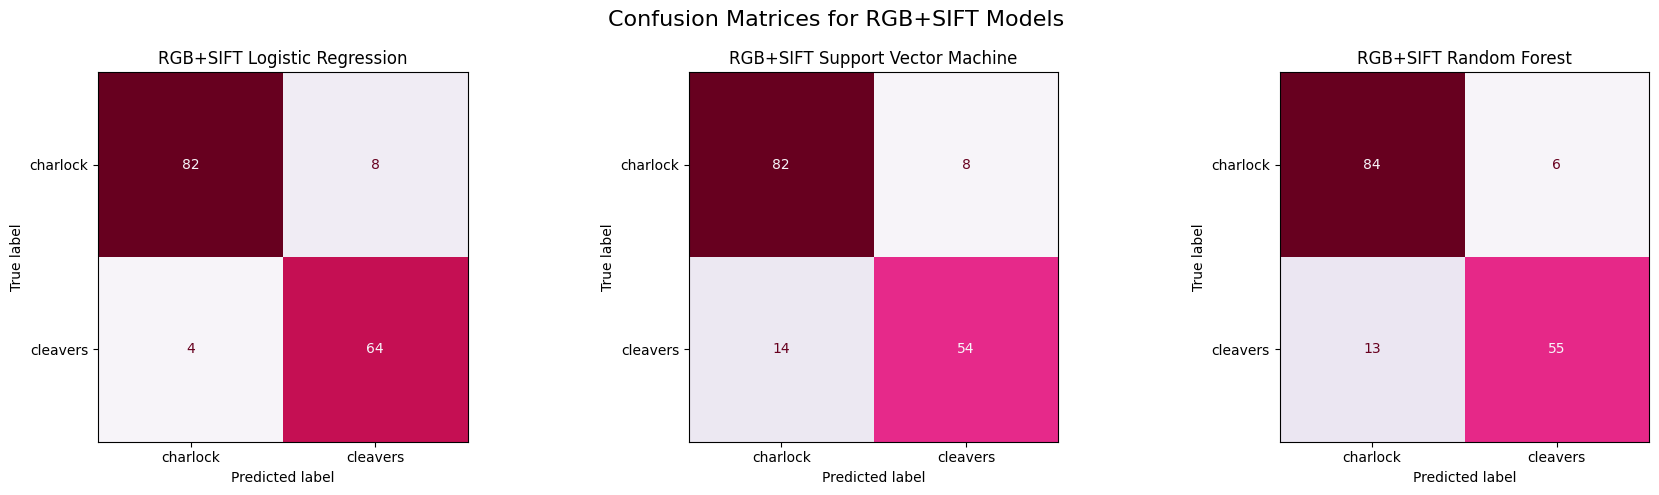


 RGB+SIFT Logistic Regression
 Accuracy:  0.9241
 Precision: 0.9212
 F1 Score:  0.9231

 RGB+SIFT Support Vector Machine
 Accuracy:  0.8608
 Precision: 0.8626
 F1 Score:  0.8562

 RGB+SIFT Random Forest
 Accuracy:  0.8797
 Precision: 0.8838
 F1 Score:  0.8756


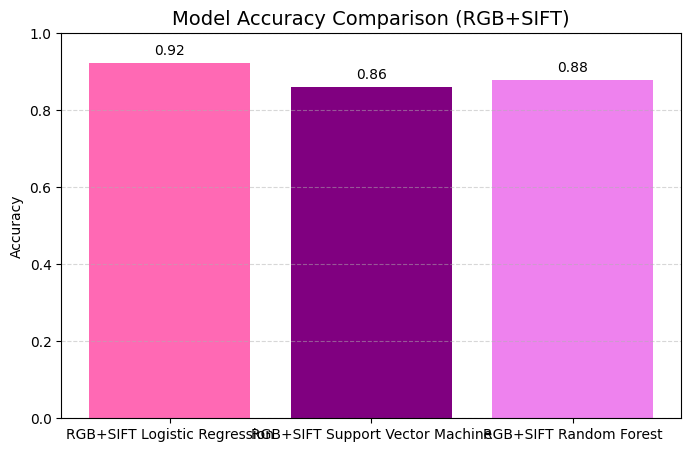

In [311]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Loading RGB + SIFT features and labels
X, y = joblib.load('features_rgb_sift.pkl')

# Splitting and scale the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training models
logreg = LogisticRegression(max_iter=1000)
svm = SVC()
rf = RandomForestClassifier()

logreg.fit(X_train_scaled, y_train)
svm.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)

# Predictions
logreg_preds = logreg.predict(X_test_scaled)
svm_preds = svm.predict(X_test_scaled)
rf_preds = rf.predict(X_test_scaled)

# Evaluation metrics
models = {
    "RGB+SIFT Logistic Regression": logreg_preds,
    "RGB+SIFT Support Vector Machine": svm_preds,
    "RGB+SIFT Random Forest": rf_preds
}

accuracies = []
precisions = []
f1_scores = []

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Horizontal layout
fig.suptitle("Confusion Matrices for RGB+SIFT Models", fontsize=16)

for idx, (name, preds) in enumerate(models.items()):
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average='macro')
    f1 = f1_score(y_test, preds, average='macro')

    accuracies.append(acc)
    precisions.append(prec)
    f1_scores.append(f1)
    
    # Define a function to print scores and confusion matrix

    cm = confusion_matrix(y_test, preds, labels=logreg.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
    disp.plot(ax=axes[idx], cmap="PuRd", colorbar=False)
    axes[idx].set_title(f"{name}")

plt.tight_layout()
plt.show()

# Bar chart of accuracies
model_names = list(models.keys())
colors = ['hotpink', 'purple', 'violet']
for name, preds in models.items():
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds, average='macro')
    f1 = f1_score(y_test, preds, average='macro')
    print(f"\n {name}")
    print(f" Accuracy:  {accuracy:.4f}")
    print(f" Precision: {precision:.4f}")
    print(f" F1 Score:  {f1:.4f}")

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, accuracies, color=colors)
plt.title("Model Accuracy Comparison (RGB+SIFT)", fontsize=14)
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add text labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center', fontsize=10)

plt.show()


RGB+HOG Log Regression:
  Accuracy : 0.8734
  Precision: 0.8702
  F1 Score : 0.8718

RGB+HOG SVM:
  Accuracy : 0.9051
  Precision: 0.9077
  F1 Score : 0.9022

RGB+HOG Random Forest:
  Accuracy : 0.9177
  Precision: 0.9168
  F1 Score : 0.9159



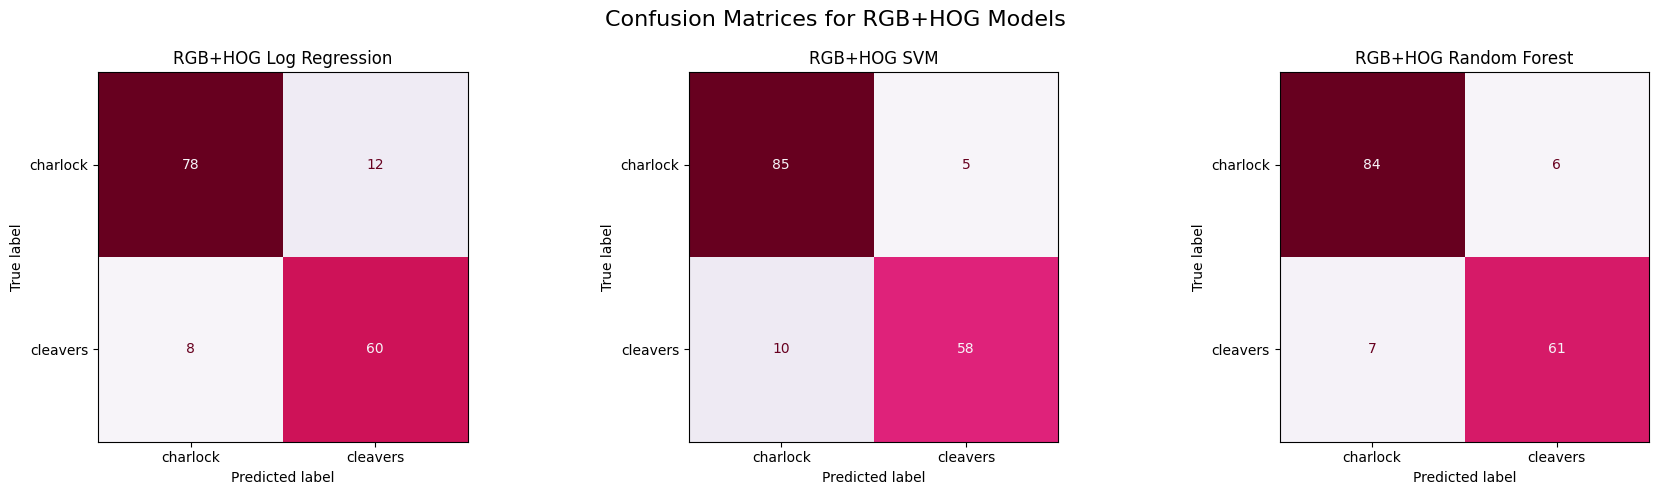

In [312]:
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Loading RGB + HOG features and labels
X, y = joblib.load('features_rgb_hog.pkl')

# Splitting and scale the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training models
logreg = LogisticRegression(max_iter=1000)
svm = SVC()
rf = RandomForestClassifier()

logreg.fit(X_train_scaled, y_train)
svm.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)

# Predictions
logreg_preds = logreg.predict(X_test_scaled)
svm_preds = svm.predict(X_test_scaled)
rf_preds = rf.predict(X_test_scaled)

# Defining models dictionary for easy iteration
models = {
    "RGB+HOG Log Regression": logreg_preds,
    "RGB+HOG SVM": svm_preds,
    "RGB+HOG Random Forest": rf_preds
}

# Initializing lists for metrics
accuracies = []
precisions = []
f1_scores = []

# Evaluating each model
for name, preds in models.items():
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average='macro')
    f1 = f1_score(y_test, preds, average='macro')

    accuracies.append(acc)
    precisions.append(prec)
    f1_scores.append(f1)
    
    # Print Evaluation Metrics
    print(f"{name}:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  F1 Score : {f1:.4f}\n")

# Bar chart of accuracies
model_names = list(models.keys())
colors = ['hotpink', 'purple', 'violet']

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, accuracies, color=colors)
plt.title("Model Accuracy Comparison (RGB+HOG)", fontsize=14)
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adding text labels for accuracy scores
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center', fontsize=10)

plt.show()

# Confusion Matrix Display
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Confusion Matrices for RGB+HOG Models", fontsize=16)

for idx, (name, preds) in enumerate(models.items()):
    cm = confusion_matrix(y_test, preds, labels=logreg.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
    disp.plot(ax=axes[idx], cmap="PuRd", colorbar=False)
    axes[idx].set_title(f"{name}")

plt.tight_layout()
plt.show()


SECOND APPROACH

Found 480 images belonging to 2 classes.
Found 148 images belonging to 2 classes.
Found 158 images belonging to 2 classes.


/Applications/anaconda3/envs/new_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,985 (42.61 MB)

 Trainable params: 11,169,537 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

/Applications/anaconda3/envs/new_env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.6832 - loss: 0.8966 - val_accuracy: 0.3919 - val_loss: 0.7882
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9606 - loss: 0.1121 - val_accuracy: 0.3919 - val_loss: 0.8326
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9743 - loss: 0.0679 - val_accuracy: 0.3919 - val_loss: 0.9603
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9960 - loss: 0.0133 - val_accuracy: 0.3919 - val_loss: 1.1625
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9922 - loss: 0.0147 - val_accuracy: 0.3919 - val_loss: 2.0083
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9916 - loss: 0.0190 - val_accuracy: 0.3919 - val_loss: 2.4561
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.3919 - val_loss: 2.0281
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.3919 - val_loss:

/Applications/anaconda3/envs/new_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/envs/new_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/envs/new_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

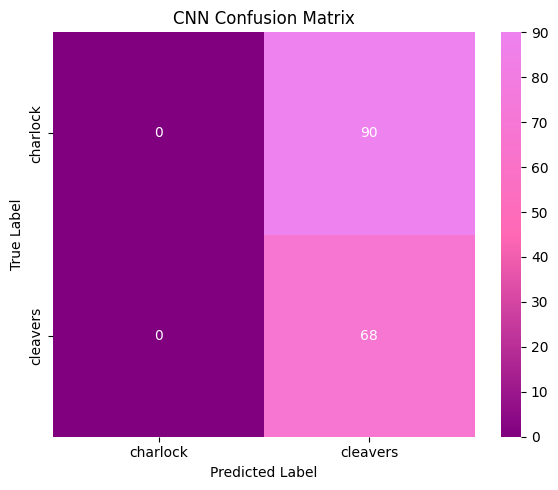

In [314]:
# CNN-Based Image Classification  SECOND APPROACH

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.colors as mcolors


# Parameters and Paths, batch size and number of epochs

base_dir = 'data weed classification'  
img_size = 224
batch_size = 32
epochs = 10


# Creating Data Generators for training/val/testing

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


# CNN Model Definition Defining the CNN Architecture

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


# Training the Model on Training data

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)


# Evaluating on Test Set and making predictions on the test data

y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).ravel()
y_true = test_generator.classes

# Classification Report Printing
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['charlock', 'cleavers']))

# Plotting the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap = mcolors.LinearSegmentedColormap.from_list("", [(0, "purple"), (0.5, "hotpink"), (1, "violet")]),
            xticklabels=['charlock', 'cleavers'],
            yticklabels=['charlock', 'cleavers'])
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [43]:
# load and normalize preprocessed data
data_dir = "preprocessed_data"
splits = ['train', 'val', 'test']
classes = ['charlock', 'cleavers']


images = []
labels = []

for split in splits:
    for cls in classes:
        folder = os.path.join(data_dir, split, cls)
        for file in tqdm(os.listdir(folder), desc=f"{split}/{cls}"):
            file_path = os.path.join(folder, file)
            image = cv2.imread(file_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224,224))
            image = image/255
            images.append(image)
            labels.append(cls)

# convert image data to numpy array for easy computation 
images = np.array(images)

# encode labels
le = LabelEncoder()
labels = le.fit_transform(labels)

# splidata into training, validation and test sets
X_train, xval_test, y_train, yval_test = train_test_split(images, labels, test_size=0.4, random_state=42, stratify=labels)

X_val, X_test, y_val, y_test = train_test_split(xval_test, yval_test, test_size=0.52, random_state=42, stratify=yval_test)


test/cleavers: 100%|███████████████████████████| 68/68 [00:00<00:00, 159.03it/s]


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
Classification Report:
              precision    recall  f1-score   support

    charlock       0.53      0.24      0.33        87
    cleavers       0.41      0.70      0.51        64

    accuracy                           0.44       151
   macro avg       0.47      0.47      0.42       151
weighted avg       0.47      0.44      0.41       151



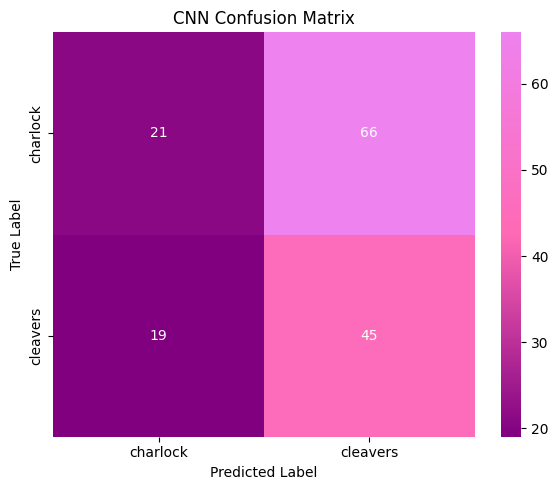

In [41]:
# classification report and confusion matrix for validation set

y_pred = (model.predict(X_val)>0.5).astype('int32')
y_pred = np.argmax(y_pred, axis=1)
y_true = y_val

# Classification Report Printing
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['charlock', 'cleavers']))

# Plotting the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap = mcolors.LinearSegmentedColormap.from_list("", [(0, "purple"), (0.5, "hotpink"), (1, "violet")]),
            xticklabels=['charlock', 'cleavers'],
            yticklabels=['charlock', 'cleavers'])
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### PART TWO: TEXT PROCESSING

In [316]:
#Loading the Dataset
import pandas as pd

# Loading CSV
df = pd.read_csv('amazon_reviews.csv')

# Checking label distribution
print(df['sentiments'].value_counts())


sentiments
positive    9503
neutral     6303
negative    1534
Name: count, dtype: int64


In [317]:
print(df.isnull().sum())

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64


In [318]:
df.loc[:, 'cleaned_review'] = df['cleaned_review'].fillna('No review text available')


In [319]:
# Preprocessing 
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = ''.join([c for c in text if c not in string.punctuation])
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['Preprocessed_text'] = df['cleaned_review'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hannahsmart/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [320]:
# showing the first 5 rows to compare the cleaned review to the preprocessed text
df.head()

sentiments                                     cleaned_review  \
0   positive  i wish would have gotten one earlier love it a...   
1    neutral  i ve learned this lesson again open the packag...   
2    neutral          it is so slow and lags find better option   
3    neutral  roller ball stopped working within months of m...   
4    neutral  i like the color and size but it few days out ...   

   cleaned_review_length  review_score  \
0                     19           5.0   
1                     88           1.0   
2                      9           2.0   
3                     12           1.0   
4                     21           1.0   

                                   Preprocessed_text  
0  wish would gotten one earlier love make work l...  
1  learn lesson open packag use product right awa...  
2                        slow lag find better option  
3  roller ball stop work within month minim use p...  
4       like color size day return period hold charg

In [321]:
# Data Splitting into Train/Val/Test
from sklearn.model_selection import train_test_split

X = df['Preprocessed_text']
y = df['sentiments']

# Train (70%), Val (15%), Test (15%) 
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42)


Logistic Regression (TF-IDF):
              precision    recall  f1-score   support

    negative       0.67      0.32      0.43       230
     neutral       0.76      0.83      0.79       946
    positive       0.89      0.91      0.90      1425

    accuracy                           0.83      2601
   macro avg       0.77      0.69      0.71      2601
weighted avg       0.82      0.83      0.82      2601



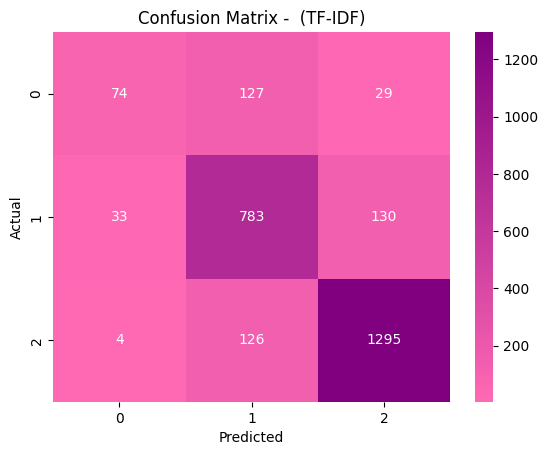

In [322]:
#Solution 1
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# performing Term Frequency - Inverse Document Frequency
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

# ModelTraining
model1 = LogisticRegression(max_iter=200)
model1.fit(X_train_tfidf, y_train)

# Model Evaluation
y_pred1 = model1.predict(X_test_tfidf)
print("Logistic Regression (TF-IDF):")
print(classification_report(y_test, y_pred1))

import matplotlib.colors as mcolors

# Define the custom colormap
barbie_pink = '#FF69B4'
purple = '#800080'
cmap = mcolors.LinearSegmentedColormap.from_list("", [barbie_pink, purple])

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred1), annot=True, fmt='d', cmap=cmap)
plt.title("Confusion Matrix - Logistic Regression (TF-IDF)")


# Confusion Matrix
#sns.heatmap(confusion_matrix(y_test, y_pred1), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix -  (TF-IDF)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [323]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Downloading required NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Initializing lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Defining clean_text function
def clean_text(text):
    if pd.isnull(text) or not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Defining preprocess function
def preprocess(text):
    text = clean_text(text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Applying preprocess function to dataframe
df['processed_text'] = df['cleaned_review'].apply(preprocess)

# Filtering dataframe
df = df[df['sentiments'].isin(['positive', 'neutral', 'negative'])]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hannahsmart/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hannahsmart/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hannahsmart/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [324]:
#Splitting the data 
from sklearn.model_selection import train_test_split

X = df['processed_text']
y = df['sentiments']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42)


TF-IDF
              precision    recall  f1-score   support

    negative       0.64      0.29      0.40       230
     neutral       0.75      0.83      0.79       946
    positive       0.89      0.91      0.90      1425

    accuracy                           0.82      2601
   macro avg       0.76      0.68      0.69      2601
weighted avg       0.82      0.82      0.81      2601



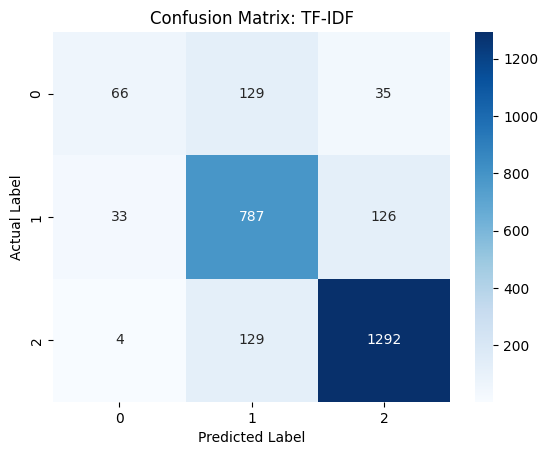

In [397]:
#TF-IDF+Logistic Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

model1 = LogisticRegression(max_iter=200)
model1.fit(X_train_tfidf, y_train)
y_pred1 = model1.predict(X_test_tfidf)

print("TF-IDF")
print(classification_report(y_test, y_pred1))




sns.heatmap(confusion_matrix(y_test, y_pred1), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: TF-IDF")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()


In [326]:
# trying out countvector to see the one that works best

Count Vectorizer:
              precision    recall  f1-score   support

    negative       0.70      0.57      0.63       230
     neutral       0.79      0.83      0.81       946
    positive       0.91      0.91      0.91      1425

    accuracy                           0.85      2601
   macro avg       0.80      0.77      0.78      2601
weighted avg       0.85      0.85      0.85      2601



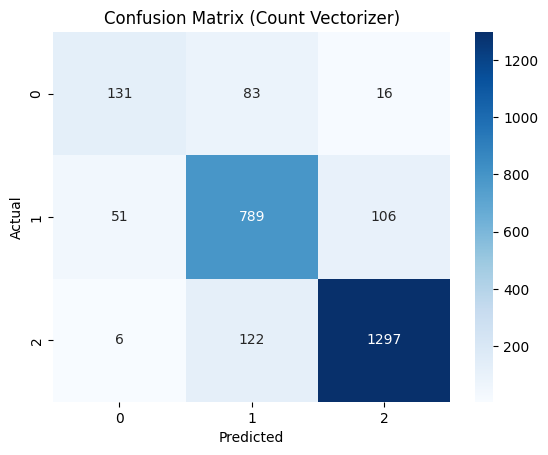

In [327]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_features=5000)
X_train_count = count_vect.fit_transform(X_train)
X_val_count = count_vect.transform(X_val)
X_test_count = count_vect.transform(X_test)

# Model
model1 = LogisticRegression(max_iter=200)
model1.fit(X_train_count, y_train)

# Evaluation
y_pred1 = model1.predict(X_test_count)
print("Count Vectorizer:")
print(classification_report(y_test, y_pred1))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred1), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Count Vectorizer)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Epoch 1/5


/Applications/anaconda3/envs/new_env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


190/190 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.6201 - loss: 0.8205 - val_accuracy: 0.7815 - val_loss: 0.5202
Epoch 2/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.8435 - loss: 0.4084 - val_accuracy: 0.8227 - val_loss: 0.4686
Epoch 3/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.8919 - loss: 0.2965 - val_accuracy: 0.8435 - val_loss: 0.4315
Epoch 4/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.9218 - loss: 0.2302 - val_accuracy: 0.8478 - val_loss: 0.4447
Epoch 5/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9376 - loss: 0.1844 - val_accuracy: 0.8493 - val_loss: 0.4599
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Tokenizer + LSTM
              precision    recall  f1-score   support

    negative       0.70      0.57      0.62       230
     neutral       0.78      0.85      0.81       946
    positive       0.92      0.88      0.90      1425

    accuracy                           0.84      2601
   macro avg       0.80      0.77   

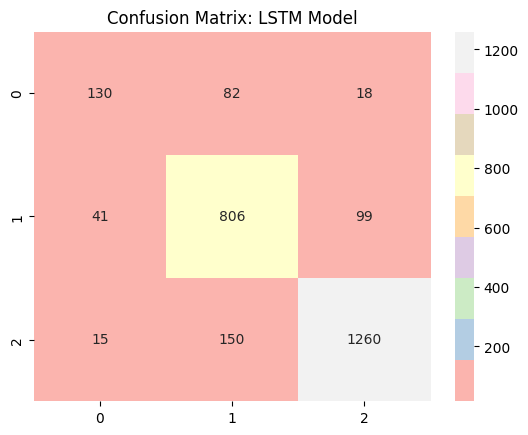

In [328]:
####SOLUTION 2
# Importing neccessary library 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder

# Creating a Tokenizer with a vocabilary size of 10,000 words
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")

# Fitting it on the Train data
tokenizer.fit_on_texts(X_train)

# Converting textdata and padding them to a fixed length
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=100)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)

# Encoding the labels
le = LabelEncoder()

# Fitting and transforming  the labels
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# Defining LSTM model
model2 = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=100),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax') #activating for multiclass
])

# Compiling the model
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
model2.fit(X_train_seq, y_train_enc, validation_data=(X_val_seq, y_val_enc), epochs=5, batch_size=64)

# Predicting on the text data
y_pred2 = model2.predict(X_test_seq)
y_pred2_labels = np.argmax(y_pred2, axis=1) # predicted labels


print("Tokenizer + LSTM")
print(classification_report(y_test_enc, y_pred2_labels, target_names=le.classes_))

# Plotting 
sns.heatmap(confusion_matrix(y_test_enc, y_pred2_labels), annot=True, fmt='d', cmap='Pastel1')
plt.title("Confusion Matrix: LSTM Model")
plt.show()
